In [2]:
import os
import pandas as pd
import numpy as np
import re
import fnmatch
import yfinance as yf
import time
from bs4 import BeautifulSoup
from tqdm import tqdm  # Progress bar for loops
import requests
from requests_html import HTMLSession
from utils.near_regex import *  # Contextual sentiment analysis
import glob
from sec_edgar_downloader import Downloader
from tqdm import tqdm 
import shutil
from zipfile import ZipFile

# Ensure output directory exists
os.makedirs("output", exist_ok=True)

In [3]:
sp500_file = 'inputs/sp500.csv'

# get it if we haven't 
if not os.path.exists(sp500_file):
    # 2022 dec version of page
    url = 'https://en.wikipedia.org/w/index.php?title=List_of_S%26P_500_companies&oldid=1130173030'
    pd.read_html(url)[0].to_csv(sp500_file,index=False)

# load and look at it
sp500 = pd.read_csv(sp500_file) 

sp500.head(10)

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded,Accession Number,Filing Dates,5-Day Return (%),BHR Positive Count,BHR Negative Count,LM Positive Count,LM Negative Count
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902,0000066740-22-000010,2022-02-09,-4.894901642693785,1611.0,1834.0,257.0,1295.0
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916,0000091142-22-000028,2022-02-11,-0.15424593099550296,704.0,654.0,100.0,344.0
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,0001104659-22-025141,2022-02-18,3.2793970775906254,901.0,1007.0,157.0,466.0
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),0001551152-22-000007,2022-02-18,2.596676113214846,1045.0,1124.0,333.0,751.0
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,0001467373-22-000295,2022-10-12,5.594433474732396,1227.0,1038.0,376.0,687.0
5,ATVI,Activision Blizzard,reports,Communication Services,Interactive Home Entertainment,"Santa Monica, California",2015-08-31,718877,2008,0001628280-22-003992,2022-02-25,Ticker\nATVI NaN\nATVI NaN\ndtype: float64,1219.0,1517.0,302.0,860.0
6,ADM,ADM,reports,Consumer Staples,Agricultural Products,"Chicago, Illinois",1981-07-29,7084,1902,0000007084-22-000008,2022-02-17,2.935404363087299,1124.0,1064.0,326.0,480.0
7,ADBE,Adobe Inc.,reports,Information Technology,Application Software,"San Jose, California",1997-05-05,796343,1982,0000796343-22-000032,2022-01-21,3.650650986923855,1269.0,1143.0,536.0,710.0
8,ADP,ADP,reports,Information Technology,Data Processing & Outsourced Services,"Roseland, New Jersey",1981-03-31,8670,1949,0000008670-22-000038,2022-08-03,3.335790342299098,905.0,787.0,231.0,468.0
9,AAP,Advance Auto Parts,reports,Consumer Discretionary,Automotive Retail,"Raleigh, North Carolina",2015-07-09,1158449,1932,0001158449-22-000037,2022-02-15,-11.590306782126817,678.0,679.0,140.0,465.0


In [3]:
dl = Downloader("Lehigh", "jag325@lehigh.edu", "10k_files")

In [4]:
if not os.path.exists('10k_files/10k_files.zip'):
    
    for cik in tqdm(sp500['CIK']): # start with a small subset while we figure things out, remove later
         
        firm_folder = f'10k_files/sec-edgar-filings/{str(cik).zfill(10)}/'  # str(cik).zfill(10)   means that CIK 1234 becomes 0000001234

        # if I haven't downloaded any HTML for this firm (len=0 files on this pattern), do so
        # you could make this more precise and only look for filings during 2022 (if you were downloading across many years)
        
        if len(glob.glob(firm_folder + '/10-K/*/*.html')) == 0:
            
            dl.get("10-K", cik, 
                   limit=1,                  # get the latest filing within window
                   after="2022-01-01",       # does this download filings ON 1/1 or nah? (check)
                   before="2022-12-31",      # does this download filings ON 12/31 or nah? (check)
                   download_details =True    # download the html 
            ) 
    
        # delete the txt files as we go!!!
        # files are of the form: folder/10-K/*/*.txt
        for txt_f in glob.glob(firm_folder + '/10-K/*/*.txt'):
            os.remove(txt_f)    
    
        # pause if there is a problem and the SEC is mad at my spider
        # unneeded! sec-edgar-dl does it for us 


100%|██████████| 509/509 [00:00<00:00, 1813.11it/s]


In [5]:
sp500.head(10)

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded,Accession Number,Filing Dates,5-Day Return (%),BHR Positive Count,BHR Negative Count,LM Positive Count,LM Negative Count
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902,0000066740-22-000010,2022-02-09,-4.894901642693785,1611.0,1834.0,257.0,1295.0
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916,0000091142-22-000028,2022-02-11,-0.15424593099550296,704.0,654.0,100.0,344.0
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,0001104659-22-025141,2022-02-18,3.2793970775906254,901.0,1007.0,157.0,466.0
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),0001551152-22-000007,2022-02-18,2.596676113214846,1045.0,1124.0,333.0,751.0
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,0001467373-22-000295,2022-10-12,5.594433474732396,1227.0,1038.0,376.0,687.0
5,ATVI,Activision Blizzard,reports,Communication Services,Interactive Home Entertainment,"Santa Monica, California",2015-08-31,718877,2008,0001628280-22-003992,2022-02-25,Ticker\nATVI NaN\nATVI NaN\ndtype: float64,1219.0,1517.0,302.0,860.0
6,ADM,ADM,reports,Consumer Staples,Agricultural Products,"Chicago, Illinois",1981-07-29,7084,1902,0000007084-22-000008,2022-02-17,2.935404363087299,1124.0,1064.0,326.0,480.0
7,ADBE,Adobe Inc.,reports,Information Technology,Application Software,"San Jose, California",1997-05-05,796343,1982,0000796343-22-000032,2022-01-21,3.650650986923855,1269.0,1143.0,536.0,710.0
8,ADP,ADP,reports,Information Technology,Data Processing & Outsourced Services,"Roseland, New Jersey",1981-03-31,8670,1949,0000008670-22-000038,2022-08-03,3.335790342299098,905.0,787.0,231.0,468.0
9,AAP,Advance Auto Parts,reports,Consumer Discretionary,Automotive Retail,"Raleigh, North Carolina",2015-07-09,1158449,1932,0001158449-22-000037,2022-02-15,-11.590306782126817,678.0,679.0,140.0,465.0


In [6]:
files = glob.glob('10k_files/sec-edgar-filings/*/10-K/*/*.html')
print(files)
f'We have {len(files)} HTML files for {len(sp500["CIK"])} firms'



['10k_files/sec-edgar-filings/0000882095/10-K/0000882095-22-000007/primary-document.html', '10k_files/sec-edgar-filings/0000943819/10-K/0000943819-22-000010/primary-document.html', '10k_files/sec-edgar-filings/0001166691/10-K/0001166691-22-000009/primary-document.html', '10k_files/sec-edgar-filings/0000723254/10-K/0000723254-22-000019/primary-document.html', '10k_files/sec-edgar-filings/0000909832/10-K/0000909832-22-000021/primary-document.html', '10k_files/sec-edgar-filings/0000046080/10-K/0000046080-22-000023/primary-document.html', '10k_files/sec-edgar-filings/0000016732/10-K/0000016732-22-000093/primary-document.html', '10k_files/sec-edgar-filings/0001001082/10-K/0001558370-22-001816/primary-document.html', '10k_files/sec-edgar-filings/0000100517/10-K/0000100517-22-000009/primary-document.html', '10k_files/sec-edgar-filings/0001478242/10-K/0001478242-22-000041/primary-document.html', '10k_files/sec-edgar-filings/0001039684/10-K/0001039684-22-000015/primary-document.html', '10k_file

'We have 498 HTML files for 509 firms'

In [ ]:
for cik in tqdm(sp500["CIK"], desc="Assigning Accession Numbers"):
    cik_str = str(cik).zfill(10)
    firm_folder = f'10k_files/sec-edgar-filings/{cik_str}/10-K/'

    try:
        html_files = glob.glob(firm_folder + '*/primary-document.html')

        if not html_files:
            print(f"⚠️ No HTML filings found for CIK {cik_str}. Skipping...")
            continue

        # ✅ Get accession number from folder name
        accession_number = os.path.basename(os.path.dirname(html_files[0]))

        # ✅ Update sp500 DataFrame
        sp500.loc[sp500["CIK"] == cik, "Accession Number"] = accession_number
        print(f"✅ CIK {cik_str}: Accession Number -> {accession_number}")

    except Exception as e:
        print(f"❌ Error for CIK {cik_str}: {e}")

    # ✅ Delay slightly to avoid hammering any services (SEC or filesystem)
    time.sleep(0.1)

In [12]:
sp500

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded,Accession Number
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902,0000066740-22-000010
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916,0000091142-22-000028
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,0001104659-22-025141
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),0001551152-22-000007
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,0001467373-22-000295
...,...,...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997,0001041061-22-000009
499,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969,0000877212-22-000026
500,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927,0001564590-22-007160
501,ZION,Zions Bancorporation,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873,0000109380-22-000072


In [ ]:
import re
import time
from requests_html import HTMLSession
from tqdm import tqdm

session = HTMLSession()
session.headers.update({'User-Agent': 'Jeremiah Geneve jag325@lehigh.edu'})

# 🔄 Iterate over downloaded HTML files and extract filing dates
for item in tqdm(files, desc="Fetching Filing Dates"):
    segment = item.split('/')  # Split the path into segments
    cik = segment[-4]
    accession_number = segment[-2]
    url = f'https://www.sec.gov/Archives/edgar/data/{cik}/{accession_number}-index.html'

    try:
        r = session.get(url)
        r.raise_for_status()  # Ensure request was successful

        # ✅ Extract Filing Date from the SEC index page
        date_element = r.html.find(
            '#contentDiv > div:nth-child(1) > div.formContent > div:nth-child(1) > div:nth-child(2)',
            first=True
        )

        filing_date = date_element.text.strip() if date_element else None

        # ✅ Update `sp500` DataFrame with the correct Filing Date
        sp500.loc[sp500["CIK"].astype(str).str.zfill(10) == cik, "Filing Dates"] = filing_date
        sp500.loc[sp500["CIK"].astype(str).str.zfill(10) == cik, "Accession Number"] = accession_number

        print(f"✅ CIK {cik}: Filing Date -> {filing_date}")

    except requests.exceptions.RequestException as e:
        print(f"❌ Error fetching filing date for CIK {cik}: {e}")

    # ✅ Add a delay to prevent rate-limiting
    time.sleep(0.5)

In [14]:
sp500.head(60)

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded,Accession Number,Filing Dates
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902,0000066740-22-000010,2022-02-09
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916,0000091142-22-000028,2022-02-11
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,0001104659-22-025141,2022-02-18
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),0001551152-22-000007,2022-02-18
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,0001467373-22-000295,2022-10-12
5,ATVI,Activision Blizzard,reports,Communication Services,Interactive Home Entertainment,"Santa Monica, California",2015-08-31,718877,2008,0001628280-22-003992,2022-02-25
6,ADM,ADM,reports,Consumer Staples,Agricultural Products,"Chicago, Illinois",1981-07-29,7084,1902,0000007084-22-000008,2022-02-17
7,ADBE,Adobe Inc.,reports,Information Technology,Application Software,"San Jose, California",1997-05-05,796343,1982,0000796343-22-000032,2022-01-21
8,ADP,ADP,reports,Information Technology,Data Processing & Outsourced Services,"Roseland, New Jersey",1981-03-31,8670,1949,0000008670-22-000038,2022-08-03
9,AAP,Advance Auto Parts,reports,Consumer Discretionary,Automotive Retail,"Raleigh, North Carolina",2015-07-09,1158449,1932,0001158449-22-000037,2022-02-15


In [15]:
print(sp500.columns)
print(sp500.shape)

Index(['Symbol', 'Security', 'SEC filings', 'GICS Sector', 'GICS Sub-Industry',
       'Headquarters Location', 'Date first added', 'CIK', 'Founded',
       'Accession Number', 'Filing Dates'],
      dtype='object')
(503, 11)


In [16]:
sp500["Filing Dates"] = pd.to_datetime(sp500["Filing Dates"], errors="coerce")

# ✅ Filter rows with a valid filing date
valid_tickers = sp500.loc[sp500["Filing Dates"].notna(), "Symbol"].tolist()

valid_tickers

['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ATVI',
 'ADM',
 'ADBE',
 'ADP',
 'AAP',
 'AES',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AMD',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'AON',
 'APA',
 'AAPL',
 'AMAT',
 'APTV',
 'ACGL',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'AZO',
 'AVB',
 'AVY',
 'BKR',
 'BALL',
 'BAC',
 'BBWI',
 'BAX',
 'BDX',
 'WRB',
 'BRK.B',
 'BBY',
 'BIO',
 'TECH',
 'BIIB',
 'BLK',
 'BK',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BF.B',
 'CHRW',
 'CDNS',
 'CZR',
 'CPT',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CTLT',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'CNC',
 'CNP',
 'CDAY',
 'CF',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA

In [17]:
import yfinance as yf
import pandas as pd
import time
from datetime import timedelta
from tqdm import tqdm

# ✅ Define function to fetch stock data
def get_stock_data(tickers, start_date, end_date, retries=3):
    stock_data = None
    for attempt in range(retries):
        try:
            print(f"📡 Fetching stock data (Attempt {attempt+1}/{retries})...")
            stock_data = yf.download(tickers, start=start_date, end=end_date).filter(like="Close").droplevel(0, axis=1)
            return stock_data
        except Exception as e:
            print(f"⚠️ Error fetching stock data: {e}")
            time.sleep(5)  # Wait before retrying
    return None  # Return None if all attempts fail

# ✅ Convert Filing Dates to datetime format
sp500["Filing Dates"] = pd.to_datetime(sp500["Filing Dates"], errors="coerce")

# ✅ Filter valid rows
valid_rows = sp500.dropna(subset=["Filing Dates"]).copy()

# ✅ Get tickers and define date range
tickers = valid_rows["Symbol"].unique().tolist()
start_date = valid_rows["Filing Dates"].min() - timedelta(days=2)
end_date = valid_rows["Filing Dates"].max() + timedelta(days=10)

# ✅ Fetch stock data
stock_data = get_stock_data(tickers, start_date, end_date)

# ✅ Initialize return column
valid_rows["5-Day Return (%)"] = None

# ✅ Compute 5-day aggregate return per stock
def calculate_5_day_return(row):
    symbol = row["Symbol"]
    filing_date = row["Filing Dates"]

    if stock_data is not None and symbol in stock_data.columns and filing_date in stock_data.index:
        try:
            filing_price = stock_data.loc[filing_date, symbol]
            future_date = stock_data.index[stock_data.index.get_loc(filing_date) + 5]  # Get price 5 days ahead
            future_price = stock_data.loc[future_date, symbol]
            return ((future_price - filing_price) / filing_price) * 100
        except Exception:
            return None  # Handle missing prices safely
    return None

valid_rows["5-Day Return (%)"] = valid_rows.apply(calculate_5_day_return, axis=1)

# ✅ Merge returns with main dataset
sp500 = sp500.merge(valid_rows[["Symbol", "Filing Dates", "5-Day Return (%)"]], 
                    on=["Symbol", "Filing Dates"], how="left")

# ✅ Display results
sp500.head(10)


📡 Fetching stock data (Attempt 1/3)...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  501 of 501 completed

16 Failed downloads:
['DISH', 'CDAY', 'PXD', 'RE', 'CTLT', 'PKI', 'WRK', 'SIVB', 'BRK.B', 'ABC', 'FLT', 'PEAK', 'FISV', 'MRO', 'ATVI']: YFTzMissingError('possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2022-01-19 00:00:00 -> 2022-12-31 00:00:00)')


,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded,Accession Number,Filing Dates,5-Day Return (%)
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902,0000066740-22-000010,2022-02-09,-4.894889
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916,0000091142-22-000028,2022-02-11,-0.154269
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,0001104659-22-025141,2022-02-18,3.27939
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),0001551152-22-000007,2022-02-18,2.596676
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,0001467373-22-000295,2022-10-12,5.594427
5,ATVI,Activision Blizzard,reports,Communication Services,Interactive Home Entertainment,"Santa Monica, California",2015-08-31,718877,2008,0001628280-22-003992,2022-02-25,Ticker ATVI NaN ATVI NaN dtype: float64
6,ADM,ADM,reports,Consumer Staples,Agricultural Products,"Chicago, Illinois",1981-07-29,7084,1902,0000007084-22-000008,2022-02-17,2.935405
7,ADBE,Adobe Inc.,reports,Information Technology,Application Software,"San Jose, California",1997-05-05,796343,1982,0000796343-22-000032,2022-01-21,3.650651
8,ADP,ADP,reports,Information Technology,Data Processing & Outsourced Services,"Roseland, New Jersey",1981-03-31,8670,1949,0000008670-22-000038,2022-08-03,3.335776
9,AAP,Advance Auto Parts,reports,Consumer Discretionary,Automotive Retail,"Raleigh, North Carolina",2015-07-09,1158449,1932,0001158449-22-000037,2022-02-15,-11.590314


In [18]:

with open('inputs/ML_negative_unigram.txt', 'r') as file:
    BHR_negative = [line.strip().lower() for line in file]

BHR_negative.sort()
# BHR_negative


In [19]:
with open('inputs/ML_positive_unigram.txt', 'r') as file:
    BHR_positive = [line.strip().lower() for line in file]

len(BHR_negative), len(BHR_positive)
BHR_positive.sort()
# BHR_positive # not exhaustive word forms

In [20]:
file_path = "inputs/LM_MasterDictionary_1993-2021.csv"  # Update with actual path
df = pd.read_csv(file_path)
LM_positive = df[df['Positive'] > 0]['Word'].tolist()
LM_positive = [e.lower() for e in LM_positive] # to be consistent with our BHR input
df.describe() # there are negative numbers in the columns: years the word is removed!
len(LM_positive)
# LM_positive

347

In [21]:
LM_negative = df[df['Negative'] > 0]['Word'].tolist()
LM_negative = [e.lower() for e in LM_negative] # to be consistent with our BHR input
# LM_negative

In [22]:
# ✅ Load LM Master Dictionary
lm_df = pd.read_csv("inputs/LM_MasterDictionary_1993-2021.csv")

# ✅ Extract LM Positive & Negative Word Lists
LM_positive = lm_df[lm_df["Positive"] > 0]["Word"].str.lower().tolist()
LM_negative = lm_df[lm_df["Negative"] > 0]["Word"].str.lower().tolist()

# ✅ Display Word Counts
print(f" BRH Positive Words: {len(BHR_positive)}")
print(f" BRH Negative Words: {len(BHR_negative)}")
print(f" LM Positive Words: {len(LM_positive)}")
print(f" LM Negative Words: {len(LM_negative)}")

# ✅ Display First 10 Words from Each List
print("\n BRH Positive Sample:", BHR_positive)
print(" BRH Negative Sample:", BHR_negative)
print(" LM Positive Sample:", LM_positive)
print(" LM Negative Sample:", LM_negative)


 BRH Positive Words: 75
 BRH Negative Words: 94
 LM Positive Words: 347
 LM Negative Words: 2345

 BRH Positive Sample: ['above', 'achieved', 'across', 'basis', 'benefit', 'benefited', 'benefiting', 'better', 'cash', 'congrats', 'congratulations', 'continue', 'continued', 'continues', 'curious', 'delivered', 'driving', 'drove', 'exceeded', 'exceeding', 'excellent', 'expansion', 'fantastic', 'favorable', 'flow', 'gains', 'generated', 'good', 'great', 'grew', 'growing', 'growth', 'helped', 'helping', 'impressive', 'improved', 'improvement', 'improvements', 'improving', 'income', 'increase', 'increased', 'increasing', 'job', 'leverage', 'lot', 'margin', 'momentum', 'nice', 'nicely', 'operating', 'outperformance', 'outstanding', 'over', 'performance', 'pleased', 'pretty', 'proud', 'raising', 'really', 'record', 'repurchase', 'results', 'share', 'solid', 'strength', 'strong', 'success', 'sustainable', 'terrific', 'think', 'up', 'upside', 'well', 'years']
 BRH Negative Sample: ['actions', 'a

In [23]:
sp500

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded,Accession Number,Filing Dates,5-Day Return (%)
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902,0000066740-22-000010,2022-02-09,-4.894889
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916,0000091142-22-000028,2022-02-11,-0.154269
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,0001104659-22-025141,2022-02-18,3.27939
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),0001551152-22-000007,2022-02-18,2.596676
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,0001467373-22-000295,2022-10-12,5.594427
...,...,...,...,...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997,0001041061-22-000009,2022-02-23,0.337203
499,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969,0000877212-22-000026,2022-02-10,-9.24287
500,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927,0001564590-22-007160,2022-02-25,-2.089038
501,ZION,Zions Bancorporation,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873,0000109380-22-000072,2022-02-25,-7.888438


In [24]:
# Filter companies with valid filing dates
valid_companies = sp500.dropna(subset=["Filing Dates"])

lm_df = pd.read_csv("inputs/LM_MasterDictionary_1993-2021.csv")
LM_positive = set(lm_df[lm_df["Positive"] > 0]["Word"].str.lower())
LM_negative = set(lm_df[lm_df["Negative"] > 0]["Word"].str.lower())

# Initialize sentiment columns only if they don't already exist
sentiment_columns = ["BHR Positive Count", "BHR Negative Count", "LM Positive Count", "LM Negative Count"]

for col in sentiment_columns:
    if col not in valid_companies.columns:
        valid_companies[col] = 0  # Initialize column if missing

# Function to extract and clean 10-K text
def extract_10k_text(cik):
    firm_folder = f"10k_files/sec-edgar-filings/{str(cik).zfill(10)}/10-K/"
    html_files = glob.glob(firm_folder + "/*/primary-document.html")

    if not html_files:
        return None

    with open(html_files[0], "r", encoding="utf-8") as file:
        soup = BeautifulSoup(file.read(), "lxml")

    # ✅ Remove hidden elements
    for div in soup.find_all("div", {"style": "display:none"}):
        div.decompose()

    return soup.get_text().lower()

# Count sentiment words for each company
for idx, row in tqdm(valid_companies.iterrows(), total=len(valid_companies), desc="Processing 10-Ks"):
    cik = row["CIK"]
    text = extract_10k_text(cik)

    if text:
        words = text.split()  # Tokenize text

        valid_companies.at[idx, "BHR Positive Count"] = sum(1 for word in words if word in BHR_positive)
        valid_companies.at[idx, "BHR Negative Count"] = sum(1 for word in words if word in BHR_negative)
        valid_companies.at[idx, "LM Positive Count"] = sum(1 for word in words if word in LM_positive)
        valid_companies.at[idx, "LM Negative Count"] = sum(1 for word in words if word in LM_negative)

# Merge sentiment analysis data with the dataset that contains "5-Day Return (%)"
sp500 = sp500.merge(valid_companies[["CIK"] + sentiment_columns], on="CIK", how="left", suffixes=("", "_new"))

# ✅ Prevent duplicate columns from being added
for col in sentiment_columns:
    if f"{col}_new" in sp500.columns:
        sp500[col] = sp500[f"{col}_new"]
        sp500.drop(columns=[f"{col}_new"], inplace=True)

# Save the updated dataset
sp500.to_csv(sp500_file, index=False)

# Display the first few rows
sp500.head(10)


/var/folders/2s/rgjlyr356xq8fbht9p8_dttm0000gn/T/ipykernel_29792/4151790111.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_companies[col] = 0  # Initialize column if missing
/var/folders/2s/rgjlyr356xq8fbht9p8_dttm0000gn/T/ipykernel_29792/4151790111.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_companies[col] = 0  # Initialize column if missing
/var/folders/2s/rgjlyr356xq8fbht9p8_dttm0000gn/T/ipykernel_29792/4151790111.py:13: SettingWithCopyWarning: 
A value is trying to be set on a

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded,Accession Number,Filing Dates,5-Day Return (%),BHR Positive Count,BHR Negative Count,LM Positive Count,LM Negative Count
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902,0000066740-22-000010,2022-02-09,-4.894889,1611.0,1834.0,257.0,1295.0
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916,0000091142-22-000028,2022-02-11,-0.154269,704.0,654.0,100.0,344.0
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,0001104659-22-025141,2022-02-18,3.27939,901.0,1007.0,157.0,466.0
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),0001551152-22-000007,2022-02-18,2.596676,1045.0,1124.0,333.0,751.0
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,0001467373-22-000295,2022-10-12,5.594427,1227.0,1038.0,376.0,687.0
5,ATVI,Activision Blizzard,reports,Communication Services,Interactive Home Entertainment,"Santa Monica, California",2015-08-31,718877,2008,0001628280-22-003992,2022-02-25,Ticker ATVI NaN ATVI NaN dtype: float64,1219.0,1517.0,302.0,860.0
6,ADM,ADM,reports,Consumer Staples,Agricultural Products,"Chicago, Illinois",1981-07-29,7084,1902,0000007084-22-000008,2022-02-17,2.935405,1124.0,1064.0,326.0,480.0
7,ADBE,Adobe Inc.,reports,Information Technology,Application Software,"San Jose, California",1997-05-05,796343,1982,0000796343-22-000032,2022-01-21,3.650651,1269.0,1143.0,536.0,710.0
8,ADP,ADP,reports,Information Technology,Data Processing & Outsourced Services,"Roseland, New Jersey",1981-03-31,8670,1949,0000008670-22-000038,2022-08-03,3.335776,905.0,787.0,231.0,468.0
9,AAP,Advance Auto Parts,reports,Consumer Discretionary,Automotive Retail,"Raleigh, North Carolina",2015-07-09,1158449,1932,0001158449-22-000037,2022-02-15,-11.590314,678.0,679.0,140.0,465.0


In [8]:
# Topics and their synonyms
# These were my second set of contex topics I chose when I intitially thought that the first topics 
# werent getting picked up from the code but that ended up not being the actual problem 
context_topics = {
    "revenue": ["revenue", "sales", "top line", "turnover"],
    "profit": ["profit", "net income", "earnings", "bottom line"],
    "debt": ["debt", "leverage", "borrowings", "interest payments", "repayment"]
}

In [32]:
def get_clean_10k_text(cik):
    folder = f"10k_files/sec-edgar-filings/{str(cik).zfill(10)}/10-K/"
    files = glob.glob(folder + "*/primary-document.html")
    if not files:
        return ""
    with open(files[0], "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f.read(), "lxml")
    for div in soup.find_all("div", {"style": "display:none"}):
        div.decompose()
    return soup.get_text(separator=" ").lower()

In [36]:
sp500

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded,Accession Number,...,supply_chain_pos_hits,supply_chain_neg_hits,litigation_pos_hits,litigation_neg_hits,revenue_pos_hits,revenue_neg_hits,profit_pos_hits,profit_neg_hits,debt_pos_hits,debt_neg_hits
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902,0000066740-22-000010,...,0,0,0,0,0,0,0,0,0,0
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916,0000091142-22-000028,...,0,0,0,0,0,0,0,0,0,0
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,0001104659-22-025141,...,0,0,0,0,0,0,0,0,0,0
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),0001551152-22-000007,...,0,0,0,0,0,0,0,0,0,0
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,0001467373-22-000295,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,YUM,Yum! Brands,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997,0001041061-22-000009,...,0,0,0,0,0,0,0,0,0,0
505,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969,0000877212-22-000026,...,0,0,0,0,0,0,0,0,0,0
506,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927,0001564590-22-007160,...,0,0,0,0,0,0,0,0,0,0
507,ZION,Zions Bancorporation,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873,0000109380-22-000072,...,0,0,0,0,0,0,0,0,0,0


Testing for 10 - I finally got it to work 

Working test

In [ ]:
import pandas as pd
import signal
from tqdm import tqdm
from utils.near_regex import NEAR_finder  # Adjust if needed
tqdm.pandas(desc="🔍 Contextual Sentiment Analysis")

# Timeout setup - I got this from my 
class TimeoutException(Exception): pass
def timeout_handler(signum, frame):
    raise TimeoutException
signal.signal(signal.SIGALRM, timeout_handler)

# Define your contextual topics 
# These were the the combination of the old context topics and new context topics 
# I figured  id keep them anyway 
context_topics = {
    "revenue": ["revenue", "sales", "top line"],
    "profit": ["profit", "earnings", "net income", "margin"],
    "debt": ["debt", "leverage", "interest payments", "credit facility"],
    "inflation": ["inflation", "price increases", "cost pressure", "rising prices"],
    "supply_chain": ["supply chain", "logistics", "distribution delays", "shipping"],
    "litigation": ["lawsuit", "litigation", "legal case", "settlement", "court", "class action"]
}

# Initialize sentiment columns
for topic in context_topics:
    sp500[f"{topic}_pos_hits"] = 0
    sp500[f"{topic}_neg_hits"] = 0

# Add clean text column
sp500["clean_10k_text"] = sp500["CIK"].apply(get_clean_10k_text)

# Define the compute_hits function with timeout

# I set this to a 90 second timeout before skipping to the next row after running this code so many times
# I figured if the row is running for almost a minute more than 90% of the time that row would get stuck
# Obv the bot helped me to write this but the coding logic is my own  
def compute_hits_with_timeout(row, timeout_seconds=90):
    signal.alarm(timeout_seconds)  # Set the timeout
    try:
        text = row["clean_10k_text"]
        if not text:
            return pd.Series({f"{topic}_pos_hits": 0 for topic in context_topics} | 
                             {f"{topic}_neg_hits": 0 for topic in context_topics})

        result = {}
        for topic, keywords in context_topics.items():
            pos_count, _ = NEAR_finder(LM_positive, keywords, text, max_words_between=10, greedy=False, partial=True)
            neg_count, _ = NEAR_finder(LM_negative, keywords, text, max_words_between=10, greedy=False, partial=True)
            result[f"{topic}_pos_hits"] = pos_count
            result[f"{topic}_neg_hits"] = neg_count
        return pd.Series(result)
    except TimeoutException:
        print(f"Timeout for CIK {row['CIK']}, skipping...")
        return pd.Series({f"{topic}_pos_hits": 0 for topic in context_topics} | 
                         {f"{topic}_neg_hits": 0 for topic in context_topics})
    finally:
        signal.alarm(0)  # Always cancel the alarm

# Apply sentiment extraction to full sp500
hit_results = sp500.progress_apply(compute_hits_with_timeout, axis=1)

# Append result columns to sp500
sp500.update(hit_results)

# Clean up
sp500.drop(columns=["clean_10k_text"], inplace=True)

# Display confirmation
print(sp500[[col for col in sp500.columns if "_hits" in col]].describe())


In [51]:
valid_rows_8

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded,Accession Number,...,profit_neg_hits,profit_pos_hits,revenue_neg_hits,revenue_pos_hits,revenue_pos_hits,revenue_neg_hits,profit_pos_hits,profit_neg_hits,debt_pos_hits,debt_neg_hits
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902,0000066740-22-000010,...,0,0,0,0,25,37,9,27,9,16
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916,0000091142-22-000028,...,0,0,0,0,9,19,11,20,0,3
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,0001104659-22-025141,...,0,0,0,0,12,41,8,31,2,12
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),0001551152-22-000007,...,0,0,0,0,43,33,11,37,8,13
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,0001467373-22-000295,...,0,0,0,0,24,36,14,25,4,4
5,ATVI,Activision Blizzard,reports,Communication Services,Interactive Home Entertainment,"Santa Monica, California",2015-08-31,718877,2008,0001628280-22-003992,...,0,0,0,0,41,97,2,25,3,12
6,ADM,ADM,reports,Consumer Staples,Agricultural Products,"Chicago, Illinois",1981-07-29,7084,1902,0000007084-22-000008,...,0,0,0,0,25,18,18,26,10,22
7,ADBE,Adobe Inc.,reports,Information Technology,Application Software,"San Jose, California",1997-05-05,796343,1982,0000796343-22-000032,...,0,0,0,0,41,78,2,16,4,15


In [50]:
sp500

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded,Accession Number,...,supply_chain_pos_hits,supply_chain_neg_hits,litigation_pos_hits,litigation_neg_hits,revenue_pos_hits,revenue_neg_hits,profit_pos_hits,profit_neg_hits,debt_pos_hits,debt_neg_hits
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902,0000066740-22-000010,...,0,0,0,0,0,0,0,0,0,0
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916,0000091142-22-000028,...,0,0,0,0,0,0,0,0,0,0
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,0001104659-22-025141,...,0,0,0,0,0,0,0,0,0,0
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),0001551152-22-000007,...,0,0,0,0,0,0,0,0,0,0
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,0001467373-22-000295,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,YUM,Yum! Brands,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997,0001041061-22-000009,...,0,0,0,0,0,0,0,0,0,0
505,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969,0000877212-22-000026,...,0,0,0,0,0,0,0,0,0,0
506,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927,0001564590-22-007160,...,0,0,0,0,0,0,0,0,0,0
507,ZION,Zions Bancorporation,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873,0000109380-22-000072,...,0,0,0,0,0,0,0,0,0,0


In [42]:
sp500.columns


Index(['Symbol', 'Security', 'SEC filings', 'GICS Sector', 'GICS Sub-Industry',
       'Headquarters Location', 'Date first added', 'CIK', 'Founded',
       'Accession Number', 'Filing Dates', '5-Day Return (%)',
       'BHR Positive Count', 'BHR Negative Count', 'LM Positive Count',
       'LM Negative Count', 'inflation_pos_hits', 'inflation_neg_hits',
       'supply_chain_pos_hits', 'supply_chain_neg_hits', 'litigation_pos_hits',
       'litigation_neg_hits', 'revenue_pos_hits', 'revenue_neg_hits',
       'profit_pos_hits', 'profit_neg_hits', 'debt_pos_hits', 'debt_neg_hits'],
      dtype='object')

In [4]:
#This took 160 minutes to run, thank god I had the Idea of saving this so that i didnt have to run it again if I ever came back to this
wsent = pd.read_csv('output/sp500_with_sentiment.csv')

wsent.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded,Accession Number,...,profit_pos_hits,profit_neg_hits,debt_pos_hits,debt_neg_hits,inflation_pos_hits,inflation_neg_hits,supply_chain_pos_hits,supply_chain_neg_hits,litigation_pos_hits,litigation_neg_hits
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902,0000066740-22-000010,...,13,31,9,17,0,6,4,12,19,218
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916,0000091142-22-000028,...,11,20,0,3,2,1,2,7,1,6
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,0001104659-22-025141,...,12,36,2,10,2,2,2,8,1,25
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),0001551152-22-000007,...,12,38,10,14,0,0,3,1,3,85
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,0001467373-22-000295,...,16,28,4,4,1,2,1,3,3,25


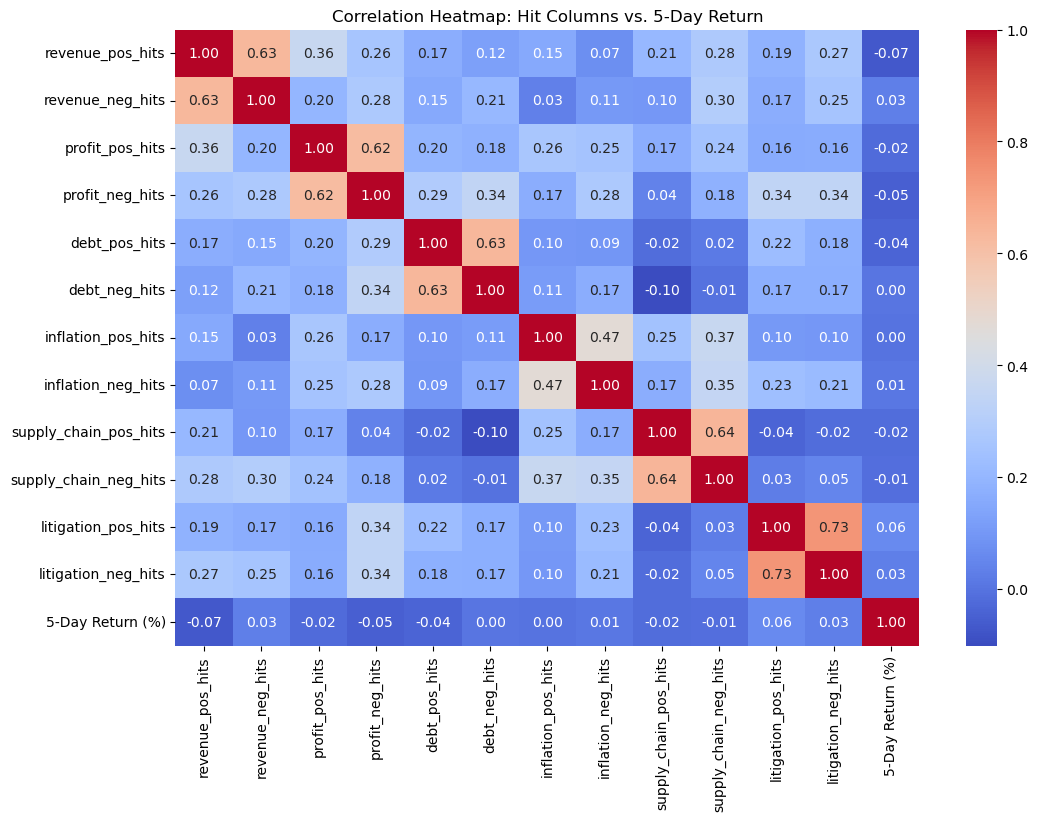

In [6]:
# Step 1: Filter columns that contain "hit" and are numeric
hit_cols = [col for col in wsent.columns if 'hit' in col and pd.api.types.is_numeric_dtype(wsent[col])]

# Step 2: Ensure '5-Day Return (%)' is numeric
wsent['5-Day Return (%)'] = pd.to_numeric(wsent['5-Day Return (%)'], errors='coerce')

# Step 3: Append it to the hit columns list if it's valid
if '5-Day Return (%)' in wsent.columns:
    hit_cols.append('5-Day Return (%)')

# Step 4: Drop rows with NaN in the selected columns
heatmap_data = wsent[hit_cols].dropna()

# Step 5: Plot the correlation heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap: Hit Columns vs. 5-Day Return')
plt.show()